## Deep Backwards Stochastic Differential Equation

### Implementing the Neural Network for $Z_\theta$ and $q_\theta$

We aim to solve the following stochastic optimal control problem using the **deep BSDE approach**.

---

#### Market Dynamics

- The mid-price evolves as:

$$
dP(t) = \left[ \mu^P + \psi(q(t)) \right] dt + \sigma^P\, dW^P(t)
$$

where $\psi(q) = \gamma q$ is the **permanent impact**.

- The residual demand evolves as:

$$
dD(t) = \rho\,\sigma^D\,dW^P(t) + \sqrt{1 - \rho^2}\,\sigma^D\,dW^D(t)
$$

- The imbalance price evolves as:

$$
dB(t) = \sigma^B\,dW^B(t)
$$

---

#### Execution Price and Running Cost

The execution price includes:
- Mid-price: $P(t)$
- Half-spread: $\operatorname{sign}(q(t)) \cdot \psi(q(t))$
- Temporary impact: $\phi(q(t)) = \eta q(t)$

The **execution price** is:

$$
\tilde{P}(t, q(t)) = P(t) + \operatorname{sign}(q(t)) \psi(q(t)) + \phi(q(t))
$$

The **running cost** is the negative of trading revenue:

$$
f(t, y, q) = -q(t)\cdot\tilde{P}(t, q(t))
$$

---

#### Terminal Cost

Let the imbalance be:

$$
I(T) = X(T) - D(T) + \xi
$$

The terminal cost is:

$$
h(y(T)) = -c_{\text{prod}} \cdot \xi + I(T)^+ \cdot B(T) - I(T)^- \cdot B(T)
$$

where $I^+ = \max(I, 0)$ and $I^- = \max(-I, 0)$.

In our implementation, we set $\xi = 0$ (no conventional production for now).

---

#### Deep BSDE Formulation

We solve the value function backward using:
- State dynamics: $d\boldsymbol{y}(t) = b(t) dt + \Sigma(t)\, dW(t)$
- Value function: $Y(t) = V(t, y(t))$
- Gradient process: $Z(t) = \Sigma(t)^\top \nabla_y V(t, y(t))$

The backward dynamics are:

$$
dY(t) = -f(t, y(t), q(t)) dt + Z(t)^\top dW(t)
$$

with terminal condition:

$$
Y(T) = h(y(T))
$$

We approximate:
- $Y(0)$ as a trainable parameter,
- $Z(t) \approx Z_\theta(t, y(t))$,
- $q(t) \approx q_\theta(t, y(t))$

and minimize the terminal mismatch:

$$
\mathbb{E} \left[ \left( Y(T) - h(y(T)) \right)^2 \right]
$$

This gives a trainable loss for the neural networks representing the value function and control.


In [13]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
# ========== Hyperparameters ==========
T = 1.0
N = 40
dt = T / N
batch_size = 256
dim = 4  # state = (X, P, D, B)

# ========== Model Parameters ==========
mu_P = 0.0
sigma_P = 0.2
sigma_D = 0.1
sigma_B = 0.1
rho = -0.5
gamma = 0.0  # permanent impact
eta = 10.0     # temporary impact
c_prod = 45.0  # production cost
xi = 0.0      # initial inventory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # output shape matches dW dim
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


class QNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, y):
        inp = torch.cat([t, y], dim=1)
        return self.net(inp)


# ========== Impact Functions ==========
def psi(q): return gamma * q
def phi(q): return eta * q ** 2

# ========== Generator ==========
def generator(y, q):
    P = y[:, 1:2]  # mid-price
    sign_q = torch.sign(q)
    P_exec = P + sign_q * psi(q) + phi(q)
    return -q * P_exec  # shape: (batch, 1)

# ========== Terminal Cost ==========
def terminal_cost(y):
    X = y[:, 0]
    D = y[:, 2]
    B = y[:, 3]
    I = X - D + xi
    I_plus = torch.clamp(I, min=0.0)
    I_minus = torch.clamp(-I, min=0.0)
    return -c_prod * xi + I_plus * B - I_minus * B  # zero production for now

# ========== BSDE Solver ==========
class DeepBSDE(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], device=device))
        self.z_net = ZNetwork(state_dim).to(device)
        self.q_net = QNetwork(state_dim).to(device)

    def forward(self):
        # Initial state (X, P, D, B)
        y = torch.zeros(batch_size, dim, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        X, P, D, B = [torch.zeros(batch_size, 1, device=device) for _ in range(4)]

        Y = self.Y0.repeat(batch_size, 1)

        total_residual_loss = 0.0

        for i in range(N):
            t_input = t.clone()
            z = self.z_net(t_input, y)
            q = self.q_net(t_input, y)
            f = generator(y, q)

            dW = torch.randn(batch_size, 3, device=device) * np.sqrt(dt)
            dWP = dW[:, 0:1]
            dWD = dW[:, 1:2]
            dWB = dW[:, 2:3]

            # Forward SDE updates
            dX = q * dt
            dP = (mu_P + gamma * q) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWD
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y_next = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)

            # --- Residual loss: Enforce BSDE dynamics ---
            residual = Y_next.detach() - Y + f * dt - (z * dW).sum(dim=1, keepdim=True)
            total_residual_loss += torch.mean(residual**2)

            # Update variables
            Y = Y_next
            t += dt

        terminal = terminal_cost(y)
        terminal_loss = torch.mean((Y - terminal)**2)
        return terminal_loss + total_residual_loss / N


# ========== Training ==========
model = DeepBSDE(state_dim=dim).to(device)
try:
    model.load_state_dict(torch.load("model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("No model found, starting training from scratch.")

optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []

lowest_loss = float("inf")

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:<4}: Loss = {loss.item():.10f}")

        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            torch.save(model.state_dict(), "model.pth")
            print(f"Model saved at epoch {epoch} with loss {lowest_loss:.10f}")


Model loaded successfully.
Epoch 0   : Loss = 0.1035406962
Model saved at epoch 0 with loss 0.1035406962
Epoch 50  : Loss = 0.0004478010
Model saved at epoch 50 with loss 0.0004478010
Epoch 100 : Loss = 0.0001774735
Model saved at epoch 100 with loss 0.0001774735
Epoch 150 : Loss = 0.0001377134
Model saved at epoch 150 with loss 0.0001377134
Epoch 200 : Loss = 0.0001394500
Epoch 250 : Loss = 0.0001320734
Model saved at epoch 250 with loss 0.0001320734
Epoch 300 : Loss = 0.0000900939
Model saved at epoch 300 with loss 0.0000900939
Epoch 350 : Loss = 0.0001056591
Epoch 400 : Loss = 0.0000835368
Model saved at epoch 400 with loss 0.0000835368
Epoch 450 : Loss = 0.0000924801
Epoch 500 : Loss = 0.0000835585
Epoch 550 : Loss = 0.0001165802
Epoch 600 : Loss = 0.0000784248
Model saved at epoch 600 with loss 0.0000784248
Epoch 650 : Loss = 0.0000697502
Model saved at epoch 650 with loss 0.0000697502
Epoch 700 : Loss = 0.0000867796
Epoch 750 : Loss = 0.0000685410
Model saved at epoch 750 with lo

### Training Loss

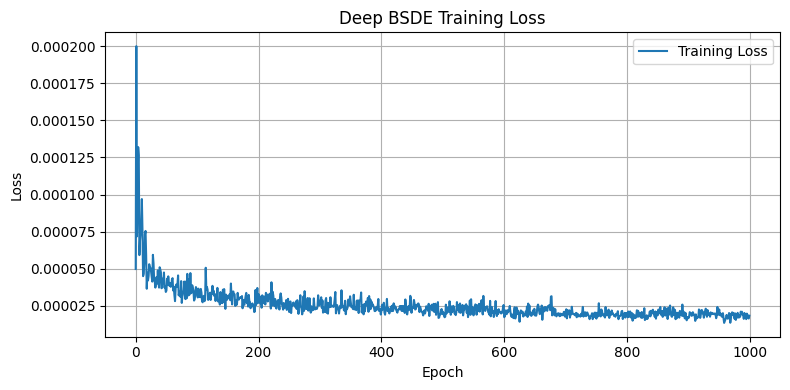

In [90]:
plt.figure(figsize=(8, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Deep BSDE Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Analysis of Results

In this section, we analyze the behavior of the learned policy and value function by comparing simulation outcomes with theoretical and economic intuition derived from the structure of the control problem.

---

#### 1. Monotonicity of the Value Function $Y(t)$

- **Theory**: The value function $Y(t)$ represents the expected remaining cost from time $t$ onward.
- **Expected Behavior**: As time progresses and the agent incurs more cost, $Y(t)$ should **decrease in expectation**.
- **Check**: Plot $\mathbb{E}[Y(t)]$ over time across many trajectories. Confirm it is a non-increasing curve.

---

#### 2. Correlation Between Position $X(T)$ and Demand $D(T)$

- **Goal**: Minimize terminal imbalance $I(T) = X(T) + \xi - D(T)$ to avoid costly settlement.
- **Expected Behavior**: Strong **positive correlation** between $X(T)$ and $D(T)$, ideally close to 1.
- **Check**: Simulate many trajectories and compute $\text{Corr}(X(T), D(T))$.

---

#### 3. Sensitivity to Imbalance Prices $B(T)$

- **Economic Intuition**: If terminal imbalance prices are high (large $B(T)$), the agent should reduce imbalance more aggressively.
- **Expected Behavior**:
  - When $B(T)$ is large, the absolute imbalance $|I(T)|$ should be small.
- **Check**:
  - Plot $|I(T)|$ vs. $B(T)$. Look for a **negative trend**.
  - Group samples by bins of $B(T)$, and compute average imbalance per bin.

---

#### 4. Behavior of Optimal Control $q(t)$

- **Smoothness**: With linear impact functions and no strict terminal constraints, optimal control should vary **smoothly** over time.
- **Variability**: More aggressive control in earlier steps if:
  - Imbalance risk is high (e.g. large $\sigma^B$),
  - Demand is volatile (large $\sigma^D$),
  - Price impact is low (small $\eta$, $\gamma$).

- **Check**:
  - Plot $\mathbb{E}[q(t)] \pm \text{CI}$ over time.
  - Plot control across many demand states $D(0)$, confirm monotonicity if prices are linear.

---

#### 5. Zero-Trading Baseline Comparison

- **Rationale**: A passive policy with $q(t) = 0$ should perform worse than the learned policy.
- **Check**:
  - Simulate the zero-trade strategy.
  - Compare its terminal cost $h(y(T))$ to the learned $Y(0)$.
  - The learned strategy should have a lower expected cost.

---

#### 6. Balance at Terminal Time

- **With no production ($\xi = 0$)**, we expect:
  $$
  X(T) \approx D(T) \quad \Rightarrow \quad I(T) \approx 0
  $$
  - Especially when $B(T)$ is high.

- **With production allowed**, the agent should dispatch production optimally to reduce the final imbalance.

- **Check**:
  - Compare $X(T) + \xi$ vs. $D(T)$ over samples.
  - If production is enabled, ensure it follows merit order.

---

#### 7. Confidence Intervals Reflect Risk

- **Value function**: High variance of $Y(t)$ may indicate regions of uncertainty or volatility.
- **Control**: Wide confidence intervals in $q(t)$ suggest unstable decision zones.

- **Check**:
  - Plot 95% CI for both $Y(t)$ and $q(t)$.
  - Interpret widening intervals over time or across state slices.

---

#### 8. Consistency with HJB and BSDE Duality

- **Mathematical Consistency**: The learned $Y(t)$ and $Z(t)$ should approximately satisfy the backward dynamics:
  $$
  dY(t) = -f(t, y(t), q(t)) dt + Z(t)^\top dW(t)
  $$
- **Check**:
  - Simulate forward paths and compute empirical discrepancy between $Y(T)$ and terminal cost $h(y(T))$.
  - The MSE loss should be small at convergence.

---

By validating these properties, we ensure both **theoretical correctness** and **economic realism** of the learned trading and hedging strategy.


#### Overall check

In [91]:
def simulate_all(model, n_paths=1000, y0_single=None, seed=42):
    torch.manual_seed(seed)
    model.eval()
    N_paths = n_paths
    n_batches = N_paths // batch_size
    n_steps = N
    dim_w = 3

    q_trajectories = []
    y_trajectories = []
    Y_trajectories = []
    terminal_stats = {"X": [], "D": [], "B": [], "I": []}

    for _ in range(n_batches):
        y = torch.zeros(batch_size, dim, device=device)
        if y0_single is not None:
            y = y0_single.repeat(batch_size, 1).to(device)
        X, P, D, B = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]
        t = torch.zeros(batch_size, 1, device=device)

        q_traj = []
        Y = model.Y0.repeat(batch_size, 1)
        Y_traj = []
        y_traj = []

        for _ in range(n_steps):
            t_input = t.clone()
            q = model.q_net(t_input, y).squeeze(-1)
            z = model.z_net(t_input, y)
            f = generator(y, q.unsqueeze(-1))

            dW = torch.randn(batch_size, dim_w, device=device) * np.sqrt(dt)
            dWP, dWT, dWB = dW[:, 0:1], dW[:, 1:2], dW[:, 2:3]

            q_input = q.unsqueeze(-1)
            dX = q_input * dt
            dP = (mu_P + gamma * q_input) * dt + sigma_P * dWP
            dD = rho * sigma_D * dWP + np.sqrt(1 - rho**2) * sigma_D * dWT
            dB = sigma_B * dWB

            X = X + dX
            P = P + dP
            D = D + dD
            B = B + dB
            y = torch.cat([X, P, D, B], dim=1)

            Y = Y - f * dt + (z * dW).sum(dim=1, keepdim=True)

            t += dt
            q_traj.append(q.detach().cpu().numpy())
            Y_traj.append(Y.detach().cpu().numpy())
            y_traj.append(y.detach().cpu().numpy())

        q_trajectories.append(np.stack(q_traj, axis=0))
        Y_trajectories.append(np.stack(Y_traj, axis=0))
        y_trajectories.append(np.stack(y_traj, axis=0))

        I = X - D + xi
        terminal_stats["X"].append(X.detach().cpu())
        terminal_stats["D"].append(D.detach().cpu())
        terminal_stats["B"].append(B.detach().cpu())
        terminal_stats["I"].append(I.detach().cpu())

    results = {
        "q": np.concatenate(q_trajectories, axis=1),
        "Y": np.concatenate(Y_trajectories, axis=1),
        "final_y": np.concatenate(y_trajectories, axis=1),
        "X_T": torch.cat(terminal_stats["X"]).squeeze().numpy(),
        "D_T": torch.cat(terminal_stats["D"]).squeeze().numpy(),
        "B_T": torch.cat(terminal_stats["B"]).squeeze().numpy(),
        "I_T": torch.cat(terminal_stats["I"]).squeeze().numpy()
    }

    return results

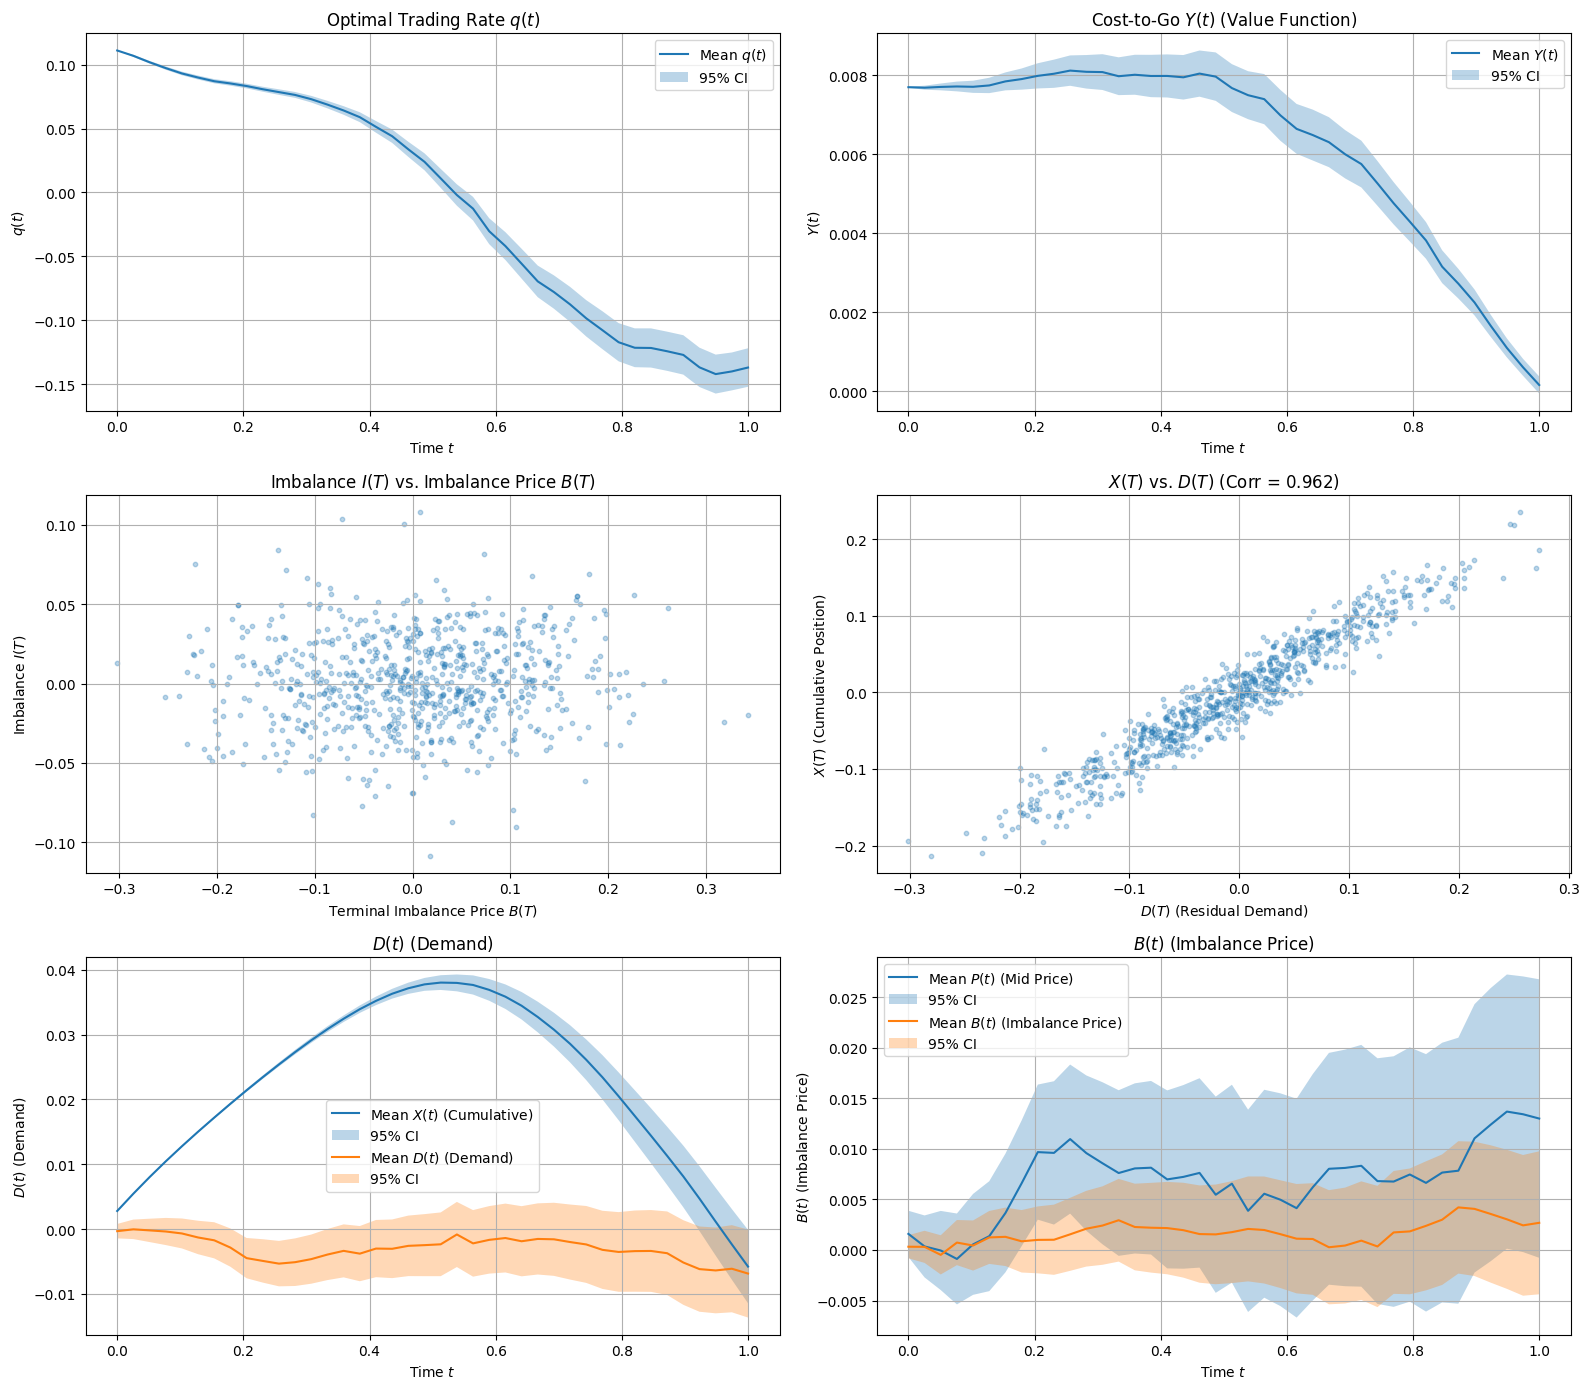

In [95]:
def plot_all_diagnostics(results, timesteps):

    q_vals = results["q"]  # shape: (T, N)
    Y_vals = results["Y"]
    X_T, D_T, B_T, I_T = results["X_T"], results["D_T"], results["B_T"], results["I_T"]

    # Retrieve the state trajectories (assumed shape: (N*T, 4))
    y_all = results["final_y"]  # shape: (T * n_paths, 4)
    n_paths = q_vals.shape[1]
    T = q_vals.shape[0]
    state_trajectories = y_all.reshape(T, -1, 4)

    mean_states = state_trajectories.mean(axis=1)
    std_states = state_trajectories.std(axis=1)
    ci_states = 1.96 * std_states / np.sqrt(n_paths)

    fig, axs = plt.subplots(3, 2, figsize=(16, 14))

    # Subplot 1: Control over time
    mean_q = q_vals.mean(axis=1)
    std_q = q_vals.std(axis=1)
    ci_q = 1.96 * std_q / np.sqrt(n_paths)
    axs[0, 0].plot(timesteps, mean_q, label="Mean $q(t)$")
    axs[0, 0].fill_between(timesteps, mean_q - ci_q, mean_q + ci_q, alpha=0.3, label="95% CI")
    axs[0, 0].set_title("Optimal Trading Rate $q(t)$")
    axs[0, 0].set_xlabel("Time $t$")
    axs[0, 0].set_ylabel("$q(t)$")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Subplot 2: Value function over time
    mean_Y = Y_vals.mean(axis=1).squeeze()
    std_Y = Y_vals.std(axis=1).squeeze()
    ci_Y = 1.96 * std_Y / np.sqrt(Y_vals.shape[1])
    axs[0, 1].plot(timesteps, mean_Y, label="Mean $Y(t)$")
    axs[0, 1].fill_between(timesteps, mean_Y - ci_Y, mean_Y + ci_Y, alpha=0.3, label="95% CI")
    axs[0, 1].set_title("Cost-to-Go $Y(t)$ (Value Function)")
    axs[0, 1].set_xlabel("Time $t$")
    axs[0, 1].set_ylabel("$Y(t)$")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Subplot 3: Scatter of imbalance vs B(T)
    axs[1, 0].scatter(B_T, I_T, alpha=0.3, s=10)
    axs[1, 0].set_xlabel("Terminal Imbalance Price $B(T)$")
    axs[1, 0].set_ylabel("Imbalance $I(T)$")
    axs[1, 0].set_title("Imbalance $I(T)$ vs. Imbalance Price $B(T)$")
    axs[1, 0].grid(True)

    # Subplot 4: X(T) vs D(T)
    axs[1, 1].scatter(D_T, X_T, alpha=0.3, s=10)
    corr = np.corrcoef(X_T, D_T)[0, 1]
    axs[1, 1].set_title(f"$X(T)$ vs. $D(T)$ (Corr = {corr:.3f})")
    axs[1, 1].set_xlabel("$D(T)$ (Residual Demand)")
    axs[1, 1].set_ylabel("$X(T)$ (Cumulative Position)")
    axs[1, 1].grid(True)

    # Subplot 5: All states with confidence bands
    labels = ["$X(t)$ (Cumulative)", "$P(t)$ (Mid Price)", "$D(t)$ (Demand)", "$B(t)$ (Imbalance Price)"]
    for i in range(4):
        axs[2, i % 2].plot(timesteps, mean_states[:, i], label=f"Mean {labels[i]}")
        axs[2, i % 2].fill_between(timesteps,
                                   mean_states[:, i] - ci_states[:, i],
                                   mean_states[:, i] + ci_states[:, i],
                                   alpha=0.3, label="95% CI")
        axs[2, i % 2].set_title(labels[i])
        axs[2, i % 2].set_xlabel("Time $t$")
        axs[2, i % 2].set_ylabel(labels[i])
        axs[2, i % 2].grid(True)
        axs[2, i % 2].legend()

    plt.tight_layout()
    plt.show()

timesteps = np.linspace(0, T, N)
results = simulate_all(model, n_paths=1000, seed=np.random.randint(0, 100))
plot_all_diagnostics(results, timesteps)